# Player Clustering Tool - In Development

Loading the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans

Setup a way to identify the position from filename.

1. For goalies - Filename starts with *GK*
2. For CBs - Filename starts with *CB*
3. For FBs - Filename starts with *FB*
4. For DMs - Filename starts with *DM*
5. For CMs - Filename starts with *CM*
6. For AMs and wingers - Filename starts with *AMW*
7. For forwards - Filename starts with *CF*

Reading the WyScout excel files

In [2]:
def read_data_from_file(filename):
    '''
    
    Parameters
    ----------
    filename : str
        Filepath of the file to be read.

    Returns
    -------
    df : dataframe
        The file is read into a dataframe and returned.

    '''
    try:
        if filename.split(".")[-1] == "csv":
            df = pd.read_csv(filename)
        elif filename.split(".")[-1] == "xlsx":
            df = pd.read_excel(filename)
        return df
    except Exception as e:
        logger.error(e)
        raise

In [3]:
def fill_nans(df, value):
    '''
    
    Parameters
    ----------
    df : dataframe
        The dataframe on which the operation is to be done.
    value : int/float/str
        The value that will replace the Nan elements in the dataframe.

    Returns
    -------
    df: dataframe
        Return a dataframe that has the Nan values replaced with the input value.

    '''
    try:
        return df.fillna(value)
    except Exception as e:
        logger.error(e)
        raise

In [4]:
def percentiling_columns(df, col_names, provider="Wyscout"):
    '''

    Parameters
    ----------
    df : dataframe
        The dataframe on which the operation is to be done.
    col_names : list
        The list of columns whose percentiles are to be found.

    Returns
    -------
    df : dataframe
        The output dataframe with percentile values as column
        .

    '''
    try:
        new_df = pd.DataFrame()
        for col in col_names:
            if df[col].dtype == "object":
                continue
            #CHECK THE BELOW LINE LATER
            new_df[col] = df[col].rank(method='average').apply(lambda x: int(round(100.0*(x-1)/(len(df)-1), 0)))
        return new_df
    except Exception as e:
        logger.error(e)
        raise

In [5]:
def wyscout_data_processing_outfield(df):
    try:
        # Renaming the Wyscout columns to fit my needs
        df = df.rename(columns={'Contract expires': 'Contract expiry',
                                'Defensive duels per 90': 'Defensive duels attempted per 90',
                                'Aerial duels per 90': 'Aerial duels attempted per 90',
                                'PAdj Sliding tackles': 'Sliding tackles per 90',
                                'PAdj Interceptions': 'Interceptions per 90',
                                'Crosses per 90': 'Crosses attempted per 90',
                                'Dribbles per 90': 'Dribbles attempted per 90',
                                'Fouls suffered per 90': 'Fouls won per 90',
                                'Head goals': 'Headed goals',
                                'Head goals per 90': 'Headed goals per 90',
                                'Passes per 90': 'Passes attempted per 90', 
                                'Forward passes per 90': 'Forward passes attempted per 90',
                                'Long passes per 90': 'Long passes attempted per 90',
                                'Smart passes per 90': 'Smart passes attempted per 90',
                                'Passes to final third per 90': 'Passes to final third attempted per 90',
                                'Passes to penalty area per 90': 'Passes to penalty area attempted per 90',
                                'Through passes per 90': 'Through balls attempted per 90',
                                'Accurate through passes, %': 'Accurate through balls, %',
                                'Progressive passes per 90': 'Progressive passes attempted per 90'})

        # Creating new useful metrics from the existing ones
        df['Market value'] = df['Market value']/1000000
        df['90s'] = df['Minutes played']/90
        df['Defensive duels won per 90'] = df['Defensive duels attempted per 90']*df['Defensive duels won, %']/100
        df['Aerial duels won per 90'] = df['Aerial duels attempted per 90']*df['Aerial duels won, %']/100
        df['Bookings per 90'] = df['Yellow cards per 90']+df['Red cards per 90']
        df['Bookings per foul'] = df['Bookings per 90']/df['Fouls per 90']
        df['Goal contributions per 90'] = df['Goals per 90']+df['Assists per 90']
        df['Non-penalty goal contributions per 90'] = df['Non-penalty goals per 90']+df['Assists per 90']
        df['npxG per 90'] = df['xG per 90']-(df['Penalties taken']/df['90s'])*0.76
        df['npxG per shot'] = df['npxG per 90']/df['Shots per 90']
        df['npxG + xA per 90'] = df['npxG per 90']+df['xA per 90']
        df['np:G-xG per 90'] = df['Goals per 90']-df['npxG per 90']
        df['A-xA per 90'] = df['Assists per 90']-df['xA per 90']
        df['Non-headed goals'] = df['Goals']-df['Headed goals']
        df['Non-headed goals per 90'] = df['Goals per 90']-df['Headed goals per 90']
        df['Crosses completed per 90'] = df['Crosses attempted per 90']*df['Accurate crosses, %']/100
        df['Dribbles completed per 90'] = df['Dribbles attempted per 90']*df['Successful dribbles, %']/100
        df['Passes completed per 90'] = df['Passes attempted per 90']*df['Accurate passes, %']/100
        df['Forward passes completed per 90'] = df['Forward passes attempted per 90']*df['Accurate forward passes, %']/100
        df['Long passes completed per 90'] = df['Long passes attempted per 90']*df['Accurate long passes, %']/100
        df['Goal creating involvements per 90'] = df['Assists per 90'] + df['Second assists per 90'] + df['Third assists per 90']
        df['Smart passes completed per 90'] = df['Smart passes attempted per 90']*df['Accurate smart passes, %']/100
        df['Passes to final third completed per 90'] = df['Passes to final third attempted per 90']*df['Accurate passes to final third, %']/100
        df['Passes to penalty area completed per 90'] = df['Passes to penalty area attempted per 90']*df['Accurate passes to penalty area, %']/100
        df['Through balls completed per 90'] = df['Through balls attempted per 90']*df['Accurate through balls, %']/100
        df['Progressive passes completed per 90'] = df['Progressive passes attempted per 90']*df['Accurate progressive passes, %']/100

        # Now rounding the values of approapriate columns to 2 decimal points
        str_cols = ['Player', 'Team', 'Position', 'Age', 'Contract expiry', 'Foot', 'Height']
        for col in df.columns:
            if col not in str_cols:
                df[col] = df[col].round(2)


        return df
    except Exception as e:
        logger.error(e)
        raise

In [6]:
goalkeeping_metrics = ['Short/medium passes attempted per 90', 'Long passes attempted per 90', 'Accurate short/medium passes, %', 
                      'Accurate long passes, %', 'Average pass length, m', 'Save rate, %', 'PSxG per shot', 'PSxG-GA per 90',
                      'Claims/punches attempted per 90', 'Claims/punches attempted under pressure per 90']

In [7]:
defender_metrics = ['Successful defensive actions per 90', 'Defensive duels attempted per 90', 'Aerial duels attempted per 90', 
                    'Defensive duels won, %', 'Aerial duels won, %', 'Interceptions per 90', 'Sliding tackles per 90', 
                    'Fouls per 90', 'Bookings per 90', 'Bookings per foul']

In [8]:
centreback_passing_metrics = ['Passes attempted per 90', 'Accurate passes, %',
                               'Forward passes attempted per 90', 'Long passes attempted per 90',
                               'Average pass length, m', 'Average long pass length, m',
                               'Progressive passes attempted per 90',  'Passes to final third attempted per 90',
                               'Smart passes attempted per 90', 'Goal creating involvements per 90']

In [9]:
fullback_attacking_metrics = ['Crosses attempted per 90', 'Progressive passes attempted per 90',  
                   'Passes to final third attempted per 90', 'Passes to penalty area attempted per 90', 
                   'Through balls attempted per 90', 'Shot assists per 90', 
                   'xA per 90', 'Goal creating involvements per 90', 
                   'Smart passes attempted per 90', 'Key passes per 90']

In [10]:
midfielder_passing_metrics = ['Progressive passes attempted per 90',  'Passes to final third attempted per 90',
                    'Forward passes attempted per 90', 'Passes to penalty area attempted per 90',
                    'Through balls attempted per 90', 'Shot assists per 90',
                    'xA per 90', 'Goal creating involvements per 90', 
                    'Smart passes attempted per 90', 'Key passes per 90']

In [11]:
attackers_creativity_metrics = ['Non-penalty goal contributions per 90', 'npxG + xA per 90',
                    'xA per 90', 'Shot assists per 90', 
                    'Through balls attempted per 90', 'Goal creating involvements per 90', 
                    'Smart passes attempted per 90', 'Key passes per 90', 
                    'Passes to penalty area attempted per 90', 'Dribbles completed per 90']

In [12]:
output_metrics = ['Non-penalty goals per 90', 'Headed goals per 90', 'npxG per 90', 'npxG per shot', 'np:G-xG per 90', 
                 'Shots per 90', 'Touches in box per 90', 'Fouls won per 90', 'Progressive runs per 90', 'Accelerations per 90']

Input the filename and the position of the players - GK (goalkeepers), CB (centre backs), FB (full backs and wing backs), DM/CM (midfielders), AMW (Attacking mids and wingers), FW(forwards)

Also, keep only the relevant metrics needed for the position.

In [13]:
# File path
filename = "CFs.xlsx"

# Position of the players to be clustered
position = "FW"

In [14]:
try:
    df = pd.read_excel(filename)
    if position == "GK":
        df = wyscout_data_processing_gks(df)
    else:
        df = wyscout_data_processing_outfield(df)
    
    df = fill_nans(df, 0)
    
    # If you want to filter by 90s played
    # df = df[df['90s'] >= 10]
except Exception as e:
    print("No data or something went wrong")

In [15]:
# Filering only the required columns/features

cols = []
def_cols = ['Player', 'Team', 'Position', 'Age', 'Market value', 'Contract expiry', 'Foot', 'Height']

if position == "GK":
    cols = def_cols + goalkeeping_metrics
elif position == "CB":
    cols = def_cols + defender_metrics + centreback_passing_metrics
elif position == "FB":
    cols = def_cols + defender_metrics + fullback_attacking_metrics
elif position == "CM" or position == "DM":
    cols = def_cols + defender_metrics + midfielder_passing_metrics
elif position == "AMW":
    cols = def_cols + defender_metrics + attackers_creativity_metrics + output_metrics
elif position == "FW":
    cols = def_cols + attackers_creativity_metrics + output_metrics

df = df[cols]

Check for multicollinearity and remove them

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

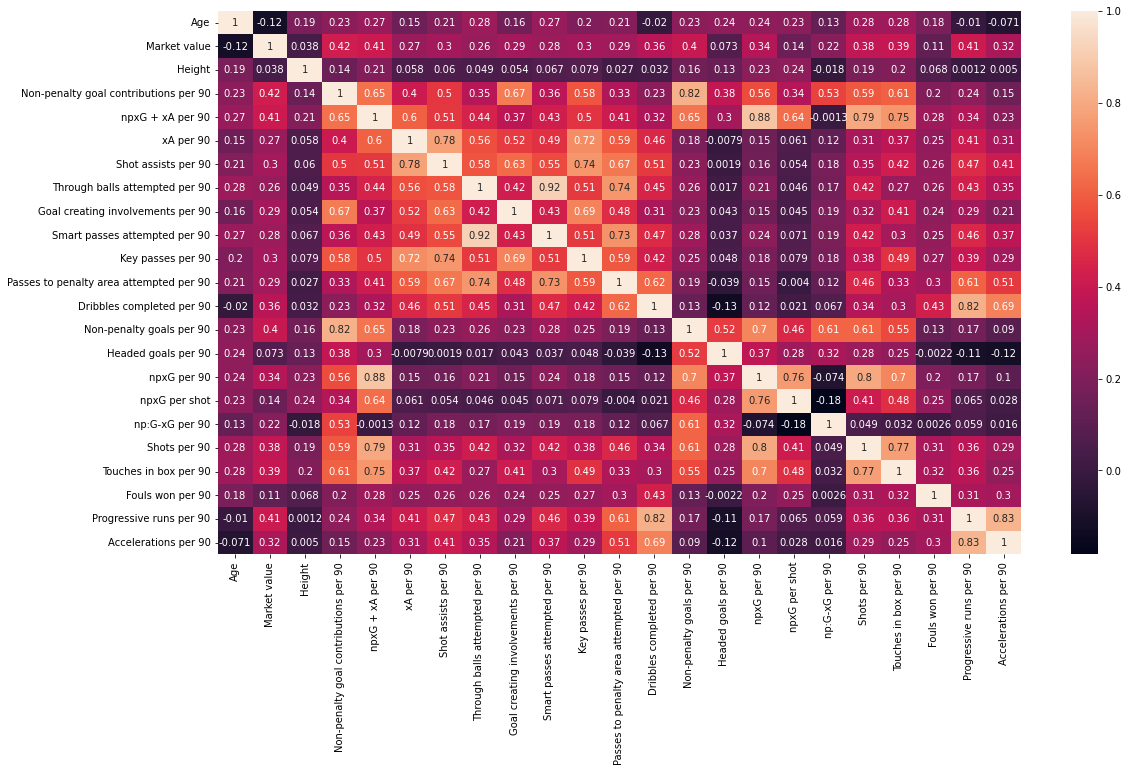

In [17]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()

In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
def multicollinearity_check_VIF(df, cont_var):
    X = df[cont_var]
    X = X.fillna(0)
    
    # Add a constant before GLM
    X = sm.add_constant(X, prepend=False)
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

In [20]:
multicollinearity_check_VIF(df.copy(), [col for col in cols if col not in def_cols])

                                  variables        VIF
0     Non-penalty goal contributions per 90  19.136260
1                          npxG + xA per 90        inf
2                                 xA per 90        inf
3                       Shot assists per 90   3.958305
4            Through balls attempted per 90   7.604699
5         Goal creating involvements per 90   6.287890
6             Smart passes attempted per 90   7.185686
7                         Key passes per 90   3.912887
8   Passes to penalty area attempted per 90   4.278772
9                 Dribbles completed per 90   3.745879
10                 Non-penalty goals per 90  30.926919
11                      Headed goals per 90   1.474007
12                              npxG per 90        inf
13                            npxG per shot   3.664641
14                           np:G-xG per 90   9.025717
15                             Shots per 90   7.323210
16                    Touches in box per 90   3.730071
17        

C:\Users\rithw\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Normalising the data and doing principal component analysis (PCA) so as to reduce dimensionality and also focus more on relevant features (variance explained by the PCs)

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
new_df = df.drop(labels=def_cols, axis=1)

In [23]:
# Assuming our data follows a normal distribution, we will now use a standard scaler to normalise/scale our data

scaler = StandardScaler()

new_df = scaler.fit_transform(new_df)

In [24]:
from sklearn.decomposition import PCA

In [37]:
# Applying PCA now - we use n_components=12 as it explains 95% of the data and we don't lose too much information

pca = PCA(n_components=3)
fit = pca.fit_transform(new_df)
#fit.explained_variance_ratio_.cumsum()

In [38]:
from sklearn.metrics import silhouette_score

In [39]:
labels = []
score = []
for k in range(2, 11, 1):
    km = KMeans(n_clusters=k)
    km.fit(fit)
    labels.append(km.labels_)
    preds = km.predict(fit)
    score.append(silhouette_score(fit, preds))

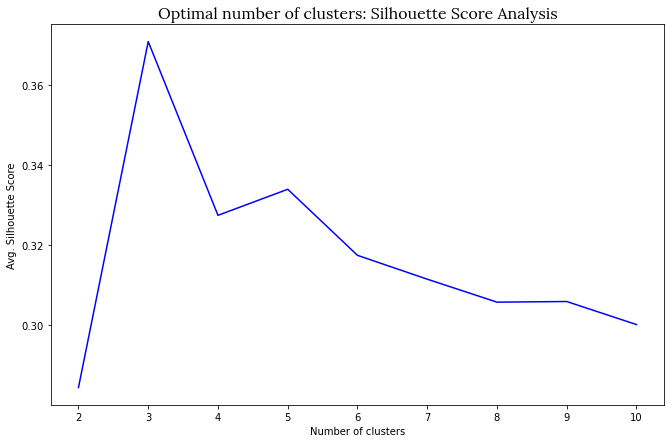

In [40]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title("Optimal number of clusters: Silhouette Score Analysis", fontname="Lora", fontsize=16)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Avg. Silhouette Score")
ax.plot(list(range(2, 11, 1)), score, 'b-')
plt.show()

In [29]:
# We will now use the optimal number of clusters
print("Optimal Number of clusters:", score.index(max(score)) + 2)

Optimal Number of clusters: 3


In [30]:
# Get all the cluster labels

clusters = labels[3] # Using number of clusters = 5

df['Cluster'] = clusters

In [31]:
df.to_excel("clustered_results.xlsx", index=False)